## Learning Outcomes
We will conduct randomization and Monte-Carlo simulation tests to determine whether a specific effect is statistically significant. Randomization and simulation tests are universal and powerful way to do this, and form an essential part of the toolkit of any Data Scientist. 
## Problem Description
In Task 1 & 2, we continue with the movie dataset. In Task 3, you are asked to program a simple monte-Carlo simulation test.  

In [14]:
# Importing packages
import matplotlib
#matplotlib.use('TkAgg')
import matplotlib.pyplot as plt 
%matplotlib inline
import seaborn as sns

import numpy as np
import pandas as pd
import scipy.stats as stats

df = pd.read_csv('movieDataset.csv')
df.head()

,Unnamed: 0,boxoff,prodcost,dirIncome,dirGender,year,month,genre,numTheatres
0,0,88.648583,44.742936,3.393535,male,2012,3,comedy,139.0
1,1,145.334924,38.835516,1.134711,female,2014,11,drama,213.0
2,2,238.265684,29.532283,2.418883,male,2015,6,other,100.0
3,3,212.714742,157.111899,2.034115,male,2014,10,adventure,436.0
4,4,120.175461,30.547155,0.963219,female,2012,1,comedy,115.0


## TASK 1: Chi-square Test of Independence
To test whether two discrete variables interact with each other, you can perform the Chi-sqaure test. The Chi-square statistic measures the deviation of the observed cell counts in a contingency table to the expected counts.

We want to test the hypothesis that there is a systematic relationship between director Gender and film genre.
> The Null-hypothesis is that film genre is independent of director Gender. The Null-hypothesis predicts that the observed cell counts do not differ (significantly) from the expected cells counts under independence.

From the table of the observed frequencies of genre / director Gender, generate a table that shows the expected frequencies if genre and gender were independent. The Marginal counts in the table should stay unchanged.

In [3]:
# Test crosstab
pd.crosstab(df['dirGender'], df['genre'])

genre,action,adventure,comedy,drama,other
dirGender,,,,,
female,9,6,13,5,4
male,48,58,35,31,41


In [5]:
# The observed values in a contingency table
obs_ctab = pd.crosstab(df['genre'], df['dirGender'])
display(obs_ctab)

# The observed values in a numpy array (matrix)
obs_array = np.array(obs_ctab)

# First, get the dimensions of the observed_array
[n_row, n_col] = obs_array.shape

# Initialize the expected_array to be all zeros
exp_array = np.zeros([n_row, n_col])


# Generate a table that shows the expected frequencies if genre and gender were independent
for i in range(n_row):
    #print(i)
    for j in range(n_col):
        #print(j)
        exp_array[i,j] = (np.sum(obs_array[i,:]) * np.sum(obs_array[:,j]))/np.sum(obs_array.flatten())

# Display expected frequencies table
display(exp_array)

dirGender,female,male
genre,,
action,9,48
adventure,6,58
comedy,13,35
drama,5,31
other,4,41


array([[ 8.436, 48.564],
       [ 9.472, 54.528],
       [ 7.104, 40.896],
       [ 5.328, 30.672],
       [ 6.66 , 38.34 ]])

Create one function that takes the data frame as input and calculates a statistics of the overall deviation between expected and observed frequencies: 
$χ^2 = \sum_i(O_i-E_i)^2/E_i)$ 

Where $O_i$ is the observed frequency for cell $i$, $E_i$ is the expected frequency for cell $i$, assuming independence of gender and genre. The sum is to be taken over all 10 cells. This test-statistic is called the Chi-square test of independence.

Report the value of this statistic for the real data. 

In [6]:
def chi_square(df):
    """
    chi_square(df): calculates a statistics of the overall deviation between expected and observed frequencies
    df - dataframe
    return test statistics
    """
    # The observed values in a contingency table
    obs_ctab = pd.crosstab(df['genre'], df['dirGender'])
    
    # The observed values in a numpy array (matrix)
    obs_array = np.array(obs_ctab)
    
    # First, get the dimensions of the observed_array
    [n_row, n_col] = obs_array.shape
    
    # Initialize the expected_array to be all zeros
    exp_array = np.zeros([n_row, n_col])
    
    # Initialize empty array for test statistics
    empty_arr = np.zeros([n_row, n_col])
    
    # Get expected_array and calculate test statistics using nested for loops
    for i in range(n_row):
        for j in range(n_col):
            # Generate a table that shows the expected frequencies if genre and gender were independent
            exp_array[i,j] = (np.sum(obs_array[i,:])*np.sum(obs_array[:,j]))/np.sum(obs_array.flatten())
            
            # Generate a table that shows deviation between expected and observed frequencies
            empty_arr[i,j] = ((obs_array[i,j] - exp_array[i,j])**2)/exp_array[i,j]
    
    # Sum up everything to calculate test statistics
    test_stat = np.sum(empty_arr.flatten())  
    
    # Return test statistics
    return test_stat
    
result = chi_square(df)
print(f'The result is: {result:.6f}')

The result is: 8.552103


Randomization with flexible input arguments
- The first argument should still be a dataframe (as before)
- The second input argument should be a function that computes the test statistics. All test-statistic functions are assumed to take the data frame as the first and only input. 
- The third input argument is the name of the dataframe column that is being shuffled. 
- An optional input argument: the number of iterations (default=500)
- An optional input argument: the number of sides of the test (1 or 2; default = 1). If the test is two-sided, then count the number of cases where the absolute value of the test statistic (np.abolute) is larger or equal to the real test statistic.
- An optional input argument: The number of bins for plotting the histogram 

In [7]:
def permutation_test(data, fcn, shuffle, numIter = 500, side = 1, n_bins = 20): 
    # Initialize the numpy array that will store the test stat
    stat = np.zeros(numIter, dtype = 'float64')
    
    ## 1. Shuffling the "exchangeable" variable
    i = 0 # Iteration variable
    while i < numIter:
        
        ## Permute (shuffle) the exchangeable variable
        # Make a copy of the dataframe so that we don't modify the original dataframe object
        tmpDf = df.copy()
        
        # Creates a new np array that will contain the indeces - These indeces will then be shuffled
        sInd  = np.array(range(len(tmpDf.index)))
        #print(tmpDf)
        
        # Shuffling the indeces (will be used to shuffle (permute) the gender)
        np.random.shuffle(sInd)
        
        # Shuffling the column
        tmpCol = tmpDf[shuffle].iloc[sInd]
        #print(tmpCol)
        
        # Reorder the shuffled indeces (the gender variable has already been shuffled)
        tmpCol = tmpCol.reset_index(drop = True) 
        #print(tmpCol)
        
        ## Insert the shuffled variable into the dataframe
        tmpDf[shuffle] = tmpCol
        #print(tmpDf)
        
        ## Calculate the test stat.
        stat[i] = fcn(tmpDf)
        
        # Increase i
        i += 1
        
    
    ## 2. Plotting the histogram of the test statistic
    plt.figure()
    plt.hist(stat, bins = n_bins)
    empStat = fcn(data)
    
    if side == 1:
        plt.axvline(x = empStat, color = 'r')
    else:       
        plt.axvline(x = -empStat, color = 'r')
        plt.axvline(x = empStat, color = 'r')
    
    plt.title("Histogram of the Test Statistics")
    plt.xlabel("Test statistics")
    plt.ylabel("Count")
    plt.show()
    
    ## 3. Calculating the p-value (one-sided)
    if side == 1:
        p_value = sum(stat >= empStat)/len(stat)
    else:
        p_value = sum(np.absolute(stat) >= empStat)/len(stat)
    
    print('P-value of the randomisation test is p = ',p_value)
    
    return p_value

Perform a randomization test for the Chi-square test of independence

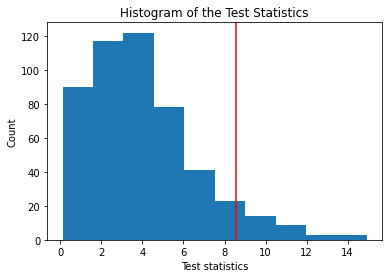

P-value of the randomisation test is p =  0.072


0.072

In [8]:
permutation_test(df, chi_square, "dirGender", 500, 1, 10)

Since p-value is larger than 0.05, we do not reject the null hypothesis that gender and genre are independent.

## TASK 2: Randomization Test for Mean Differences
In this task, we will test the hypothesis that male and female directors differ in their annual income. Note that the hypothesis is undirected, meaning it could mean either that men earn more than women, or that women earn more than men.

The corresponding Null-hypothesis is that the mean annual income for men and women directors is identical.

Write a function that calculates and returns the difference in director salaries depending on the gender (male average income – female average income). Report the value.

In [17]:
def avg_income_diff(data):
    """
    Args:
        data (pd.dataframe) - input dataset        
        
    Returns:
        diff (float) - difference between avg incomes
    """
    #groping by genrder
    income_by_gender = data['dirIncome'].groupby(data['dirGender'])
    
    #income for male
    income_m = income_by_gender.get_group('male')
    
    #income for female
    income_f = income_by_gender.get_group('female')
    
    #the difference in director salaries depending on the gender
    diff = income_m.mean() - income_f.mean()
    
    #return diff
    return diff

# test function
diff = avg_income_diff(df)
print(f'The average income difference is: {diff:.6f}')

The average income difference is: 1.222680


Use your randomization test function to perform a randomization test to determine whether the reported difference is statistical significant. Plot a histogram of the null-distribution and the real value. Report the p-value for the two-sided test.

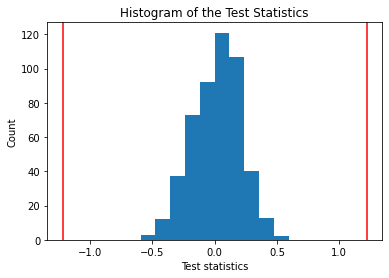

P-value of the randomisation test is p =  0.0


0.0

In [18]:
permutation_test(df, avg_income_diff, "dirGender", 500, 2, 10)

We can conclude that in our sample gender and director Salary are highly dependent, with women directors earning a different amount from male directors. While this is suggestive of gender discrimination we cannot make a causal claim (i.e. that the women made less only because of gender), as the data is from an observational study, not an experiment.

## Task 3: Monte-Carlo Simulation Test
People providing an organ for donation sometimes seek help from a medical consultant. These consultants assist the patient in all aspects of the surgery. Patients might choose a consultant based in part on the historical complication rate of the consultant's clients. Consultant R tries to attract patients by noting the average complication rate for liver donor surgeries in the US is about 10%, but her clients have had only 3 complications in the 62 liver donor surgeries she has facilitated. She claims this is strong evidence that her work meaningfully contributes to reducing complications (and therefore she should be hired!).

Write a function (monteCarloSim) that simulates coin tossing. On each trial, the function should produce a specific number (N) of coin tosses and record the number of successes (heads). It should repeat this experiment numIter number of times. The inputs to the function should be a) probability of a success on each coin toss, b) the number of coin tosses per trial (N) and c) the number of trials. The function should return an np.array(range(numIter)) that holds the recorded number of heads for all trials.

In [19]:
def monteCarloSim(p_success, N, numIter):
    """
    p_success: probability of a success on each coin toss
    N: the number of coin tosses per trial
    numIter: the number of trials
    """
    
    # Create an array to save results
    resultArr = np.array(range(numIter))
    
    # Produce a specific number (N) of coin tosses and record the number of successes (heads)
    # Repeat this experiment numIter number of times
    for i in range(numIter):
        # Produce a specific number (N) of coin tosses
        coins = np.random.choice(a = [0, 1], size = N, replace = True, p = [1-p_success, p_success])
        
        # Record the number of successes (heads)
        num_heads = np.sum(coins)
        
        # Holds the recorded number of heads for all trials
        resultArr[i] = num_heads
    
    # Return the result array
    return resultArr

In [20]:
# Test my simulator
monteCarloSim(0.5, 10, 20)

array([7, 7, 3, 6, 7, 6, 5, 4, 6, 5, 4, 7, 5, 5, 9, 6, 6, 5, 7, 4])

Write a function (monteCarloTest) that uses monteCarloSim to simulate 1000 trials. The function should also plot a histogram of the recorded number of heads, and mark the real measured number with a vertical line. The function should print out the probability that the simulated number of heads is smaller than or equal to the measured number of heads. Input arguments should be 
- the probability of a success under the Null-hypothesis, 
- the number of coin tosses per trial, and 
- the measured number of heads. 

Use the function to evaluate the probability to get 3 complications in 62 cases if the probability of a complication in the population is known to be 10%.

In [26]:
def monteCarloTest(p_success, N, observed_heads):
    """
    p_sucess: the probability of a success under the Null-hypothesis,
    N: the number of coin tosses per trial
    observed_heads: the measured number of heads
    """
    numIter = 1000
    head_array = monteCarloSim(p_success, N, numIter)
    
    # Plot the histogram for head_array
    plt.figure()
    plt.hist(head_array, bins = 10)
    plt.title("Histogram for head_array")
    plt.xlabel("Heads")
    plt.ylabel("Count")
    
    # Put a vertical line on the histogram  (represents the observed number of heads)
    plt.axvline(x = observed_heads, color = 'r')
    
    # Calculate the probability
    p_value = sum(head_array <= observed_heads)/len(head_array)
    
    # Return p value
    return p_value

P-value of the monteCarloTest is p =  0.125


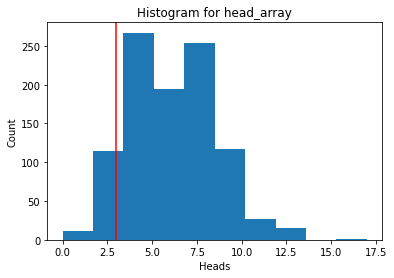

In [27]:
# Evaluate the probability to get 3 complications in 62 cases 
# If the probability of a complication in the population is known to be 10%
p_val = monteCarloTest(0.1, 62, 3)
print('P-value of the monteCarloTest is p = ',p_val)

Since we have a quite large p value (larger than 0.05), we fail to reject the null hypothesis that the medical advisor does not have any beneficial effect on the complication rate. Thus, there is no significant statistical evidence that would justify the claim that the advisor is lowering complication rates.